# Spaceship Titanic Transportation Prediction 

# Import the library

In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

# Load the Dataset

In [2]:
# Load a dataset into a Pandas Dataframe
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(df.shape))

Full train dataset shape is (8693, 14)


The data is composed of 14 columns and 8693 entries. We can see all 14 dimensions of our dataset by printing out the first 5 entries using the following code:

In [3]:
# Display the first 5 examples
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


There are 12 feature columns. Using these features your model has to predict whether the passenger is rescued or not indicated by the column `Transported`.

# Let us quickly do a basic exploration of the dataset

In [4]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Bar chart for label column: Transported



<AxesSubplot:>

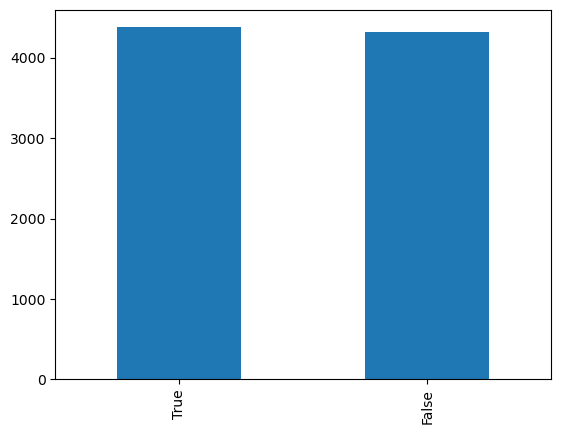

In [6]:
plot_df = df.Transported.value_counts()
plot_df.plot(kind="bar")

# Numerical data distribution

Let us plot all the numerical columns and their value counts:

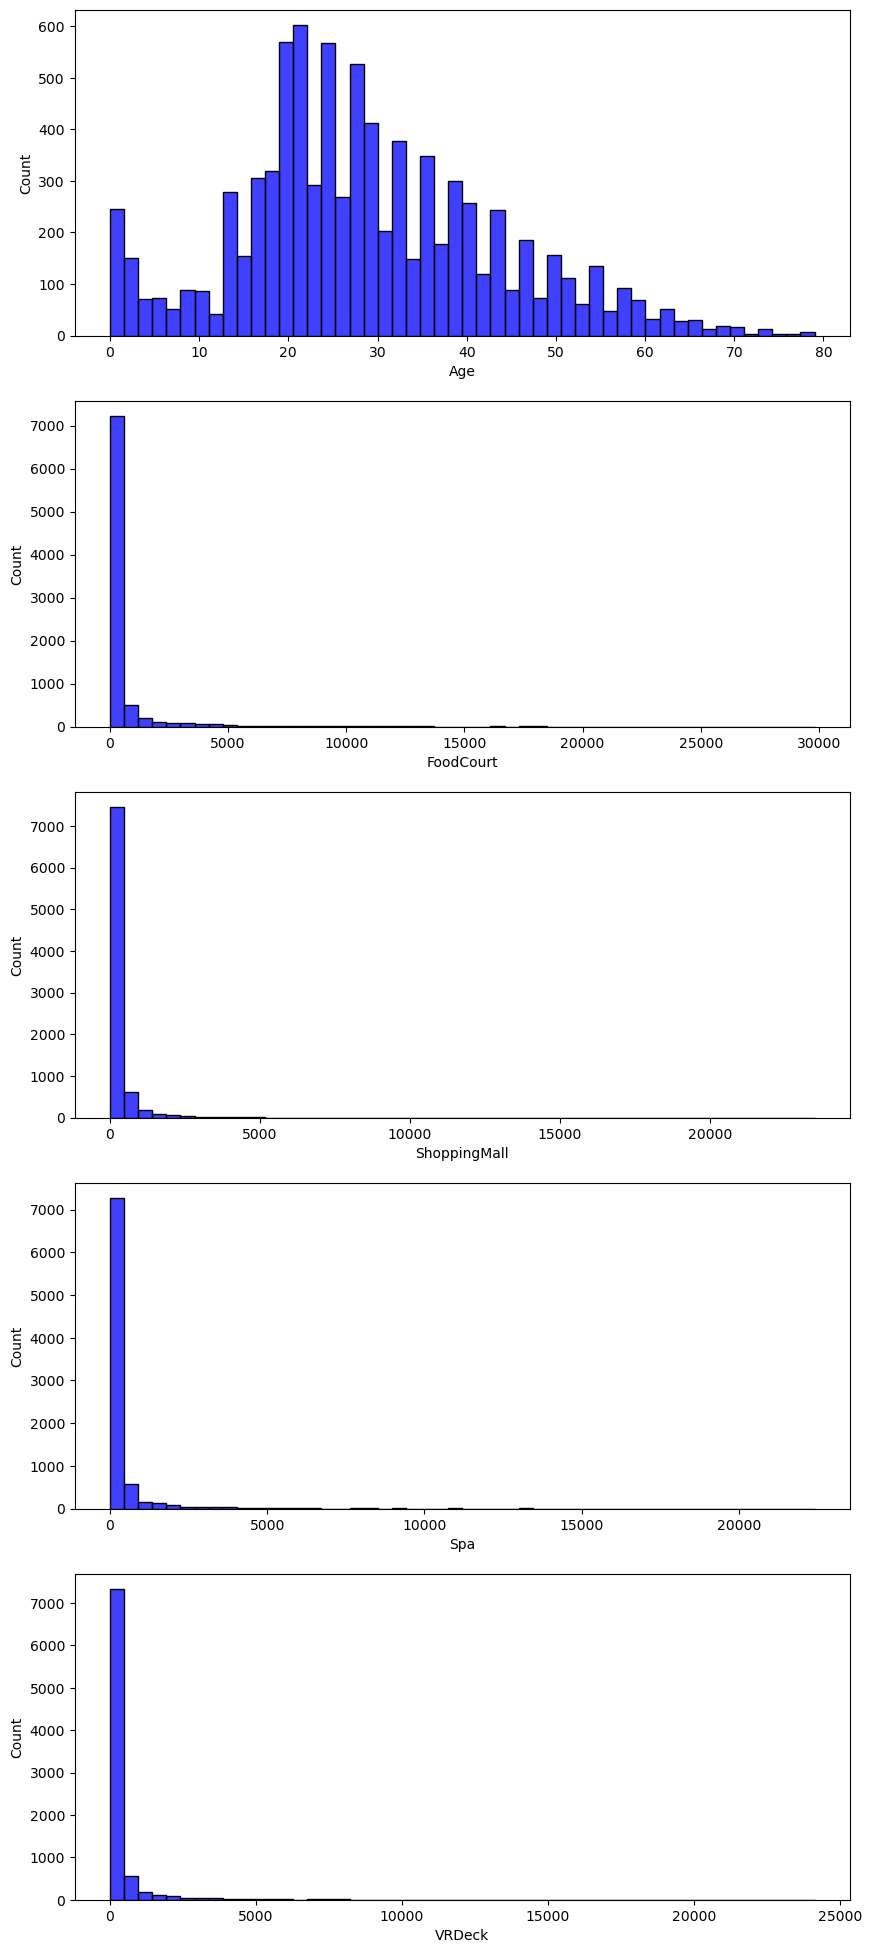

In [7]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(df['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(df['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(df['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(df['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(df['VRDeck'], color='b', bins=50, ax=ax[4]);

# Dataset Preparation

In [8]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [9]:
df = df.drop(['PassengerId', 'Name'], axis=1)

In [10]:
df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
df.isnull().sum().sort_values(ascending=False)
df.dropna()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


In [11]:
df.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [12]:
df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)

In [13]:
df["HomePlanet"] = df["HomePlanet"].astype('category')
df["Destination"] = df["Destination"].astype('category')
df["Deck"] = df["Deck"].astype('category')
df["Side"] = df["Side"].astype('category')


df.head()


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [14]:
df["hp_cat"] = df["HomePlanet"].cat.codes
df["dest_cat"] = df["Destination"].cat.codes
df["deck_cat"] = df["Deck"].cat.codes
df["side_cat"] = df["Side"].cat.codes

In [15]:
df['VIP'] = df['VIP'].astype(int)
df['CryoSleep'] = df['CryoSleep'].astype(int)
# obj_df['Cabin_num'] = obj_df['Cabin_num'].astype(int)

In [16]:
df=df.drop(['Cabin_num','HomePlanet', 'Cabin', 'Destination', 'Deck', 'Side'], axis=1)

In [17]:
df['Transported'] = df['Transported'].astype(int)

In [18]:
df.dtypes

CryoSleep         int64
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported       int64
hp_cat             int8
dest_cat           int8
deck_cat           int8
side_cat           int8
dtype: object

In [19]:
df = df[['hp_cat', 'CryoSleep', 'dest_cat', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'deck_cat', 'side_cat', 'Transported']]

In [20]:
df.head(5)

,hp_cat,CryoSleep,dest_cat,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck_cat,side_cat,Transported
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,5,1,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,5,1,1


Now let us split the dataset into training and testing datasets:

In [21]:
df = df.dropna(axis = 1)

In [22]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8693, dtype: int64


# Select a Model



# Configure the model


In [23]:
X.head()


,hp_cat,CryoSleep,dest_cat,VIP,FoodCourt,ShoppingMall,Spa,VRDeck,deck_cat,side_cat
0,1,0,2,0,0.0,0.0,0.0,0.0,1,0
1,0,0,2,0,9.0,25.0,549.0,44.0,5,1
2,1,0,2,1,3576.0,0.0,6715.0,49.0,0,1
3,1,0,2,0,1283.0,371.0,3329.0,193.0,0,1
4,0,0,2,0,70.0,151.0,565.0,2.0,5,1


# Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [24]:
# from catboost import CatBoostClassifier

# cat = CatBoostClassifier(iterations=1000,
#                            learning_rate=0.5,
#                            depth=2)

# # Fit model

# cat.fit(X_train, y_train)
# # Get predicted classes
# preds_class = cat.predict(X_test)
# x_train_pred = cat.predict(X_train)
# training_data_accuracy = accuracy_score(x_train_pred, y_train)
# x_test_pred = cat.predict(X_test)
# testing_data_accuracy = accuracy_score(x_test_pred, y_test)

# # print(model.get_best_iteration())
# print("Accuracy of training data: ",training_data_accuracy * 100)
# print("Accuracy of testing data: ",testing_data_accuracy * 100)

In [25]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166,273
Trainable params: 166,273
Non-trainable params: 0
_________________________________________________________________


In [26]:
checkpoint_name = 'best.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [27]:
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/500
153/153 [==============================] - ETA: 0s - loss: 0.8999 - mean_absolute_error: 0.8999
Epoch 1: val_loss improved from inf to 0.32997, saving model to best.hdf5
153/153 [==============================] - 2s 7ms/step - loss: 0.8999 - mean_absolute_error: 0.8999 - val_loss: 0.3300 - val_mean_absolute_error: 0.3300
Epoch 2/500
146/153 [===========================>..] - ETA: 0s - loss: 0.3340 - mean_absolute_error: 0.3340
Epoch 2: val_loss improved from 0.32997 to 0.28662, saving model to best.hdf5
153/153 [==============================] - 1s 5ms/step - loss: 0.3336 - mean_absolute_error: 0.3336 - val_loss: 0.2866 - val_mean_absolute_error: 0.2866
Epoch 3/500
143/153 [===========================>..] - ETA: 0s - loss: 0.3003 - mean_absolute_error: 0.3003
Epoch 3: val_loss did not improve from 0.28662
153/153 [==============================] - 1s 5ms/step - loss: 0.3051 - mean_absolute_error: 0.3051 - val_loss: 0.3010 - val_mean_absolute_error: 0.3010
Epoch 4/500
147/15

In [28]:
wights_file = 'best.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# Submission

In [29]:
# Load the test dataset
df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = df.PassengerId

df = df.drop(['Name'], axis=1)
df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
df.isnull().sum().sort_values(ascending=False)
df.dropna()
df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
df["HomePlanet"] = df["HomePlanet"].astype('category')
df["Destination"] = df["Destination"].astype('category')
df["Deck"] = df["Deck"].astype('category')
df["Side"] = df["Side"].astype('category')
df["hp_cat"] = df["HomePlanet"].cat.codes
df["dest_cat"] = df["Destination"].cat.codes
df["deck_cat"] = df["Deck"].cat.codes
df["side_cat"] = df["Side"].cat.codes
df['VIP'] = df['VIP'].astype(int)
df['CryoSleep'] = df['CryoSleep'].astype(int)
df=df.drop(['Cabin_num','HomePlanet', 'Cabin', 'Destination', 'Deck', 'Side'], axis=1)
df = df[['hp_cat', 'CryoSleep', 'dest_cat', 'VIP', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'deck_cat', 'side_cat']]
# Get the predictions for testdata
# hp_cat	CryoSleep	dest_cat	VIP	FoodCourt	ShoppingMall	Spa	VRDeck	deck_cat	side_cat
predictions =  NN_model.predict(df)
# print(predictions)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

134/134 [==============================] - 0s 2ms/step


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [30]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
